# Creating a Great Machine Learning Model
In this notebook we will take a walk into creating a traditional machine learning model. It differs slightly from creating one using deep learning, but some of these techniques, like pipelines can be used as well. Without further do, let's take a look into our objectives:
1. What is Gradient Descent, the Entity of ML
2. What are pipelines and how to use them
3. Creating a basic machine learning model
4. Hyperparameter tuning - dive into Grid Search, Bayesian Optimization and Optuna
5. *Dimentional reduction*

The above mentioned topics are the basics in creating and optimizing our model. In these notes I will not be covering Deep Learning and Neural Networks, since I want to create a separate repository dedicated to them, but even in these cases a lot of the knowlege from this note will apply. 

### Based on the optimalization technologies, we might differenciate a few types of models:
- **Gradient Descent based models** - these use a simple gradient descent algorithm to update the model parameters iteratively by calculating the gradient of the loss function. The parameters are ajusted in the direction of steepest descent. These would be most of our traditional models, such as:
    - Decision Trees or Random Forest;
    - Logistic or Linear Regression;
    - SVM, KNN;
    - Ensemble models (AdaBoost, XGBoost, LBGM, etc.);
- **Stochastic gradient descent models** - these are similar to the gradient descent models, however instead of using entire training set, these randomly sample individual examples to calculate the gradient. It allows for more efficient computing of large datasets. Examples for these would be:
    - Perceptrons;
    - Simple neural networks;
- **Mini-Batch Gradient Descent based models** - these again, are similar to the simple gradient model, but instead of using the whole dataset, the parameters are updated using a small subset or *mini-batch* of training examples. Withi this approch it is able to create less noise than stochastic gradient decent and faster convergence than simple gradient descent. Most popular models are:
    - Convolutional Neural Networks (CNN);
    - Recursive Neural Networks (RvNNs);
    - Transformet Neural Networks;
- **Models based on the second order optimization** - these models utilize second-order optimization methods, such as Newton's method or quasi-Newton methods like the BFGS algorithm, which take into account the curvature of the loss function to determine the optimal parameter updates, potentially achieving faster convergence than first-order methods;
- **Heuristic-based models** - these models employ heuristic optimization techniques that do not rely on explicit mathematical gradients or second-order information. They often use rules of thumb, experience-based knowledge, or domain-specific strategies to guide the optimization process, allowing for more flexibility and adaptability in certain problem domains where traditional optimization methods may not be effective or feasible.

For now, I won't be focusing on the later two types, since I have very little knowledge about them. With all these models it is important to note that the more complex the models are, the borders between these types might get blurred, as the model performance is more important than sticking to one or the other method. 

It is also worth noticing, that the firts three types rely heavily on Gradient Descent (the last 2 not so much, sometimes even not at all). Therefore, this will be our first stop.

In [1]:
# let's import our data and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read our dataset for this notebook
df = pd.read_csv('Diamonds_encoded.csv')
df.head()

,carat,cut,clarity,depth,table,price,E,F,G,H,I,J,cube
0,0.23,2,3,61.5,55.0,326,1,0,0,0,0,0,38.202030
1,0.21,3,2,59.8,61.0,326,1,0,0,0,0,0,34.505856
2,0.23,1,4,56.9,65.0,327,1,0,0,0,0,0,38.076885
3,0.29,3,5,62.4,58.0,334,0,0,0,0,1,0,46.724580
4,0.31,1,3,63.3,58.0,335,0,0,0,0,0,1,51.917250


## Gradient Descent
Gradient descent is an iterative first-order optimisation algorithm used to find a local minimum or maximum of a given function. In other words, by using gradient descent we are trying to find the best weights for our model.

It's purpose is to minimise the cost function (also known as loss function), which could be defined as a difference between the actuall output and predicted value. The smaller out loss function will be, the better predictions we will get from our model. 

To put it simply, gradient descent counts and uses the optimal derivative of loss function in relation to model parameters. Gradient descent aims to find the local minima (or minimum) in the loss function, by taking small steps toward the minimum. 
![loss function](https://miro.medium.com/max/1400/1*tQTcGTLZqnI5rp3JYO_4NA.png)
**But how does it know does it know, where is the minimum and which way to go?**  
The minimum is located, where the descent is equal to 0 (we could also say, where it is flat). The descent to the right of the minimum will always be positive (increasing) and to the left - negative (decreasing). If the descent (derivative) is negative - we have to increase it, and if positive - it needs to be decreased, so moved towards 0. These steps are repeated until minimum is reached or the next small step would overshoot the minimum with greater loss function.

**How does gradient descent know, how big the steps need to be?**  
For that we declare **learning rate** (α). It determines how fast we will converge to the extremes, i.e. how big steps we will take in each step. Its value cannot be too low, then the gradient method will be very slow, or too high - then we may never reach the minimum.
![learning rate](https://duchesnay.github.io/pystatsml/_images/learning_rate_choice.png)

**What loss functions are used?**  
Depending on the issue, we would use different loss functions. For models in sklearn, most of the models have already predetermined loss functions or there are only a few to choose from.
1. Regression:
    - Mean Squared Error (MSE)
    - Mean Absolute Error (MAE)
    - Root Mean Squared Error (RMSE)
2. Binary classification
    - Binary Cross-Entropy (Log Loss)
    - Hinge Loss (used with SVM)
3. Multi-class classification
    - Categorical Cross-Entropy (Multiclass Log Loss)
    - Sparse Categorical Cross-Entropy

Now, let's create a simple gradient descent for linear regression, as this is the easiest one 😅.

In [8]:
# for linear regression we will be predicting the price
y = df['price']
X = df[['carat']]

# for creating gradient descent, we need to prepare additional column
X = np.column_stack(([1]*len(X),X))

In [9]:
from pandas.core.computation.pytables import Constant

# let's create gradient descent function
def gradientDescent(X, y, theta, alpha, m, numIterations):
    '''
    param: X - independent variables
    param: y - dependent variable
    param: theta - matrix [Theta_0, which represents the intercept/constant term, Theta_1, which represents the coefficient for X1]
    param: alpha - learning rate - determines the size of steps to take
    param: m - number of observations
    param: numIterations - number of iterations for the model, i.e., how many steps to take
    '''
    xTrans = X.transpose()                         # required for gradient calculations (technicality)
    cost_array = np.empty([numIterations, 2])       # matrix to store the cost function value after each iteration
    for i in range(0, numIterations):               # loop
        hypothesis = np.dot(X, theta)               # take each X, multiply by theta_1, and add theta_0 - predicts house price
        loss = hypothesis - y                       # distance of points from the line, in other words, residuals/differences
        cost = np.sum(loss**2) / (2*m)              # cost function value
        print('Iteration %d | Cost %f' % (i, cost))
        cost_array[i][0] = i
        cost_array[i][1] = cost
        gradient = np.dot(xTrans, loss) / m         # partial derivative of the function
        theta = theta - alpha * gradient
    return theta, cost_array

In [36]:
# let's now create the variables and run our gradient descent
m = len(X)
numIterations = 100
alpha = 0.035
theta = [900,400] #theta0, theta1

theta,cost_array = gradientDescent(X, y, theta, alpha, m, numIterations)

Iteration 0 | Cost 10960425.684603
Iteration 1 | Cost 10214779.540554
Iteration 2 | Cost 9553137.289651
Iteration 3 | Cost 8965657.979969
Iteration 4 | Cost 8443657.080653
Iteration 5 | Cost 7979470.557181
Iteration 6 | Cost 7566334.923408
Iteration 7 | Cost 7198281.392438
Iteration 8 | Cost 6870042.469137
Iteration 9 | Cost 6576969.521877
Iteration 10 | Cost 6314960.042995
Iteration 11 | Cost 6080393.459137
Iteration 12 | Cost 5870074.486534
Iteration 13 | Cost 5681183.144356
Iteration 14 | Cost 5511230.643540
Iteration 15 | Cost 5358020.460501
Iteration 16 | Cost 5219613.986262
Iteration 17 | Cost 5094300.213222
Iteration 18 | Cost 4980568.984962
Iteration 19 | Cost 4877087.390281
Iteration 20 | Cost 4782678.931899
Iteration 21 | Cost 4696305.143672
Iteration 22 | Cost 4617049.368534
Iteration 23 | Cost 4544102.443172
Iteration 24 | Cost 4476750.065335
Iteration 25 | Cost 4414361.645980
Iteration 26 | Cost 4356380.471739
Iteration 27 | Cost 4302315.023676
Iteration 28 | Cost 4251731.

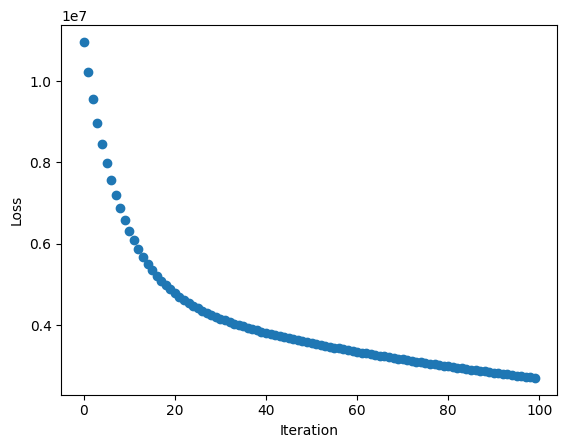

In [37]:
# now let's display how the loss function decreased
epoch = range(len(cost_array[:,0]))
plt.plot(epoch, cost_array[:,1], 'o')
plt.xlabel('Iteration')

plt.ylabel('Loss')
plt.show()

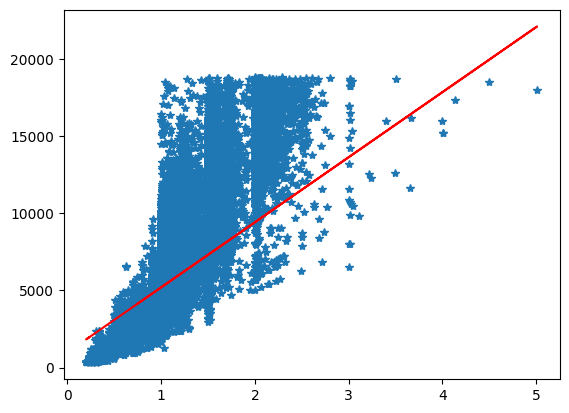

In [38]:
# and let's see how our function compares to the data
plt.plot(df['carat'], df['price'], '*')
plt.plot(df['carat'], theta[0] + df["carat"] * theta[1],'r')
plt.show()

In [40]:
#now based on the trained gradient descent let's create a prediction function
def predict_price(x, theta_0=theta[0], theta_1=theta[1]):
  result = theta_0 + theta_1 * x
  return result

# let's try and predict?
predict_price(x=0.29)

2202.8084356490913

## Pipelines